## Install some package

In [1]:
%%capture
# !pip install efficientnet_pytorch

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim


## Function Dataloader

In [3]:
class DataPreparation:
    def __init__(self, cfg):
        self.train_dir = cfg.train_dir
        self.test_dir = cfg.test_dir
        self.batch_size = cfg.batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = None
        self.classes_name = None
        self.classes2idx = None
        self.TRAINLOADER = None
        self.TESTLOADER = None

        self.prepare_transforms()
        self.load_data()
        self.create_data_loaders()

    def prepare_transforms(self):
        train_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        test_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.train_transforms = train_transforms
        self.test_transforms = test_transforms

    def load_data(self):
        train_data = torchvision.datasets.ImageFolder(root=self.train_dir, transform=self.train_transforms)
        test_data = torchvision.datasets.ImageFolder(root=self.test_dir, transform=self.test_transforms)

        self.num_classes = len(train_data.classes)
        self.classes_name = train_data.classes
        self.classes2idx = train_data.class_to_idx

        print(f"Số lượng lớp: {self.num_classes}")
        print(f"Tên lớp: {self.classes_name}")
        print(f"Ánh xạ từ tên lớp sang chỉ số: {self.classes2idx}")
        print("Number of train: ", len(train_data))
        print("Number of test: ", len(test_data))

        self.train_data = train_data
        self.test_data = test_data

    def create_data_loaders(self):
        self.trainloader = DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
        self.testloader = DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

## Function Model

In [4]:
def resnet18_frozen(num_classes):
    # Tải pre-trained ResNet-18
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    for name, param in model.named_parameters():
        if 'layer4' in name or 'fc' in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model

def mobilenetv3_frozen(num_classes):
    # Tải pre-trained MobileNetV3
    model = models.mobilenet_v3_small(pretrained=True)
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
    for name, param in model.named_parameters():
        if 'classifier' in name :
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model



## Evaluation function and visualize

In [5]:
def evaluate_model(model, test_dataloader, device, class_names):
    # Set the model in evaluation mode
    model.eval()

    all_predictions = []
    all_true_labels = []

    with torch.no_grad():
        for data in tqdm(test_dataloader, desc='eval'):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().tolist())
            all_true_labels.extend(labels.cpu().tolist())

    # Compute confusion matrix
    cm = confusion_matrix(all_true_labels, all_predictions)

    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
    return all_predictions, all_true_labels

def visualize(trainer):
    test_F1 = trainer.test_F1
    train_F1 = trainer.train_F1
    loss_test = trainer.loss_test
    loss_train = trainer.loss_train

    # Plotting the metrics
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='Train Loss')
    plt.plot(loss_test, label='Test Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_F1, label='Train F1 Score')
    plt.plot(test_F1, label='Test F1 Score')
    plt.title('F1 Score over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Function training


In [6]:
def load_best_model(model, load_path):
        model.load_state_dict(torch.load(load_path))
        return model

class Trainer:
    def __init__(self, model, train_loader, test_loader, cfg):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.patience = cfg.patience
        self.max_epochs = cfg.max_epochs
        self.device = cfg.device

        self.train_F1 = []
        self.test_F1 = []
        self.loss_train = []
        self.loss_test = []

    def train_one_epoch(self, optimizer, scheduler, criterion):
        self.model.train()
        total_loss = 0.0
        y_true = []
        y_pred = []

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            optimizer.zero_grad()
            output = self.model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            _, predicted = torch.max(output, 1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
        if scheduler is not None:
            scheduler.step()
        f1 = f1_score(y_true, y_pred, average='micro')
        self.train_F1.append(f1)
        self.loss_train.append(total_loss / len(self.train_loader))
        return self.model

    def test_one_epoch(self, criterion):
        self.model.eval()
        total_loss = 0.0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                loss = criterion(output, target)
                total_loss += loss.item()

                _, predicted = torch.max(output, 1)
                y_true.extend(target.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        f1 = f1_score(y_true, y_pred, average='micro')
        self.test_F1.append(f1)
        self.loss_test.append(total_loss / len(self.test_loader))

    def train(self, optimizer, scheduler, criterion, save_path):
        self.model.to(self.device)
        early_stopping_counter = 0
        best_f1 = -float('inf')
        model_best_f1 = None
        for epoch in tqdm(range(self.max_epochs), desc='epochs'):
            model = self.train_one_epoch(optimizer, scheduler, criterion)
            self.test_one_epoch(criterion)

            print(f"Epoch {epoch+1}/{self.max_epochs} - Train Loss: {self.loss_train[-1]:.4f} - Test Loss: {self.loss_test[-1]:.4f} - Train F1: {self.train_F1[-1]:.4f} - Test F1: {self.test_F1[-1]:.4f}")

            if self.test_F1[-1] > best_f1:
                best_f1 = self.test_F1[-1]
                early_stopping_counter = 0
                # Save the best model state dictionary
                torch.save(model.state_dict(), save_path)

            else:
                early_stopping_counter += 1

            if early_stopping_counter >= self.patience:
                print("Early stopping triggered.")
                break

        print("Training finished.")
        model_best_f1 = load_best_model(model, save_path)
        return model_best_f1


## Tuning model

In [7]:
import os
PATH_DATA = '/home/tari/Documents/BackUp_AI_Class/day04/exercise/dataset'

In [8]:
class Config:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Thiết bị sử dụng (cuda hoặc cpu)
        self.train_dir = os.path.join(PATH_DATA, 'train')  # Đường dẫn đến dữ liệu huấn luyện
        self.test_dir = os.path.join(PATH_DATA, 'test')
        self.num_classes = None
        self.class_names = None
        self.batch_size = 64
        self.max_epochs = 10
        self.patience = 3
        self.lr = 0.001
        self.beta1 = 0.95
        self.beta2 = 0.993
        self.model_name = 'mobilenet'

In [9]:
# Loss
criterion = nn.CrossEntropyLoss()
# Config
cfg = Config()
data_preparation = DataPreparation(
    cfg = cfg
    )

cfg.device

Số lượng lớp: 6
Tên lớp: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Ánh xạ từ tên lớp sang chỉ số: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Number of train:  14034
Number of test:  3000


'cuda'

In [10]:
# Create dataloader
data_preparation.create_data_loaders()
trainloader = data_preparation.trainloader
testloader = data_preparation.testloader
cfg.num_classes = data_preparation.num_classes
cfg.class_names = data_preparation.classes_name
print("Number iteration: ", len(trainloader)/cfg.batch_size)

Number iteration:  3.4375


In [11]:
# Create Model
if cfg.model_name == 'resnet':
    model = resnet18_frozen(cfg.num_classes)
elif cfg.model_name == 'mobilenet':
    model = mobilenetv3_frozen(cfg.num_classes)


/home/tari/.virtualenvs/ner/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tari/.virtualenvs/ner/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
from torchsummary import summary

In [13]:
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

In [14]:
# Create Trainer
trainer = Trainer(
    model = model,
    train_loader=trainloader,
    test_loader=testloader,
    cfg=cfg
)

In [15]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))


In [16]:
# Training
best_model = trainer.train(
    optimizer=optimizer,
    scheduler=None,
    criterion=criterion,
    save_path='best_f1.pt'
)

epochs:  10%|█         | 1/10 [00:34<05:14, 34.92s/it]

Epoch 1/10 - Train Loss: 0.4006 - Test Loss: 0.2854 - Train F1: 0.8558 - Test F1: 0.8993


epochs:  20%|██        | 2/10 [01:04<04:16, 32.05s/it]

Epoch 2/10 - Train Loss: 0.2872 - Test Loss: 0.2773 - Train F1: 0.8950 - Test F1: 0.8990


epochs:  30%|███       | 3/10 [01:34<03:37, 31.13s/it]

Epoch 3/10 - Train Loss: 0.2418 - Test Loss: 0.2623 - Train F1: 0.9109 - Test F1: 0.9077


epochs:  40%|████      | 4/10 [02:04<03:03, 30.54s/it]

Epoch 4/10 - Train Loss: 0.2078 - Test Loss: 0.3064 - Train F1: 0.9265 - Test F1: 0.8890


epochs:  50%|█████     | 5/10 [02:34<02:31, 30.35s/it]

Epoch 5/10 - Train Loss: 0.1821 - Test Loss: 0.2905 - Train F1: 0.9320 - Test F1: 0.8990


epochs:  50%|█████     | 5/10 [03:04<03:04, 36.84s/it]

Epoch 6/10 - Train Loss: 0.1554 - Test Loss: 0.2728 - Train F1: 0.9411 - Test F1: 0.9013
Early stopping triggered.
Training finished.


eval: 100%|██████████| 47/47 [00:05<00:00,  8.02it/s]


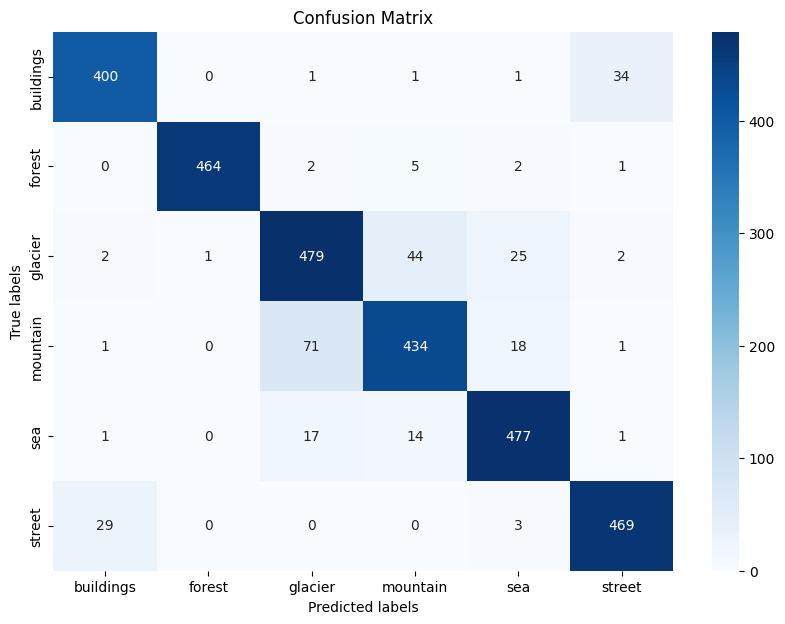

0.9076230950838632


In [17]:
all_predictions, all_true_labels = evaluate_model(
    model=best_model,
    test_dataloader = testloader,
    device = cfg.device,
    class_names = data_preparation.classes_name
)
f1 = f1_score(all_true_labels, all_predictions, average='weighted')
print(f1)

## Check model

In [18]:
model = models.mobilenet_v3_small(pretrained=True)

/home/tari/.virtualenvs/ner/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tari/.virtualenvs/ner/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model.classifier[3].in_features

1024

In [20]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight True
features.0.1.weight True
features.0.1.bias True
features.1.block.0.0.weight True
features.1.block.0.1.weight True
features.1.block.0.1.bias True
features.1.block.1.fc1.weight True
features.1.block.1.fc1.bias True
features.1.block.1.fc2.weight True
features.1.block.1.fc2.bias True
features.1.block.2.0.weight True
features.1.block.2.1.weight True
features.1.block.2.1.bias True
features.2.block.0.0.weight True
features.2.block.0.1.weight True
features.2.block.0.1.bias True
features.2.block.1.0.weight True
features.2.block.1.1.weight True
features.2.block.1.1.bias True
features.2.block.2.0.weight True
features.2.block.2.1.weight True
features.2.block.2.1.bias True
features.3.block.0.0.weight True
features.3.block.0.1.weight True
features.3.block.0.1.bias True
features.3.block.1.0.weight True
features.3.block.1.1.weight True
features.3.block.1.1.bias True
features.3.block.2.0.weight True
features.3.block.2.1.weight True
features.3.block.2.1.bias True
features.4.bloc